<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/Sentiment_analysis_IMDB_movie_review_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import svm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import load_iris, load_wine, fetch_20newsgroups, fetch_openml
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_validate
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    PolynomialFeatures
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier

In [160]:
!pip install -q datasets

## **Loading IMDB data set**

### About Dataset
IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
http://ai.stanford.edu/~amaas/data/sentiment/

examples of data analysis:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [187]:
from datasets import load_dataset

dataset_train = load_dataset('imdb',split='train')
dataset_train.rename_column('label', 'labels')
train_df=pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
dataset_test.rename_column('label', 'labels')
test_df=pd.DataFrame(dataset_test)

In [188]:
dataset_train
train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [189]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

# **Remove HTML code tags**

In [190]:
train_df['text'] = train_df['text'].replace(r'<[^<]+?>', ' ', regex=True)

In [191]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.  The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.  What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s not sh

**Remove numbers Covid19, 20th, 1965s**

In [195]:
train_df['text'] = train_df['text'].str.replace(r'\b\w*\d\w*\b', '', regex=True)
# Optional: clean up extra spaces afterward
train_df['text'] = train_df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [196]:
train_df['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in . I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself. The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. What kills me about I AM CURIOUS-YELLOW is that years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s not shot like s

In [197]:
#https://mpolinowski.github.io/docs/Development/Python/2023-05-20-python-sklearn-cheat-sheet/2023-05-20/
train_df.info()
train_df['text'].str.isspace().sum()
# is the dataset balanced
train_df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


,count
label,
0,12500
1,12500


#CountVectorizer is used to create Bag of Words (BOW)

Text(0.5, 1.0, 'Top30 Words used in Negative Reviews')

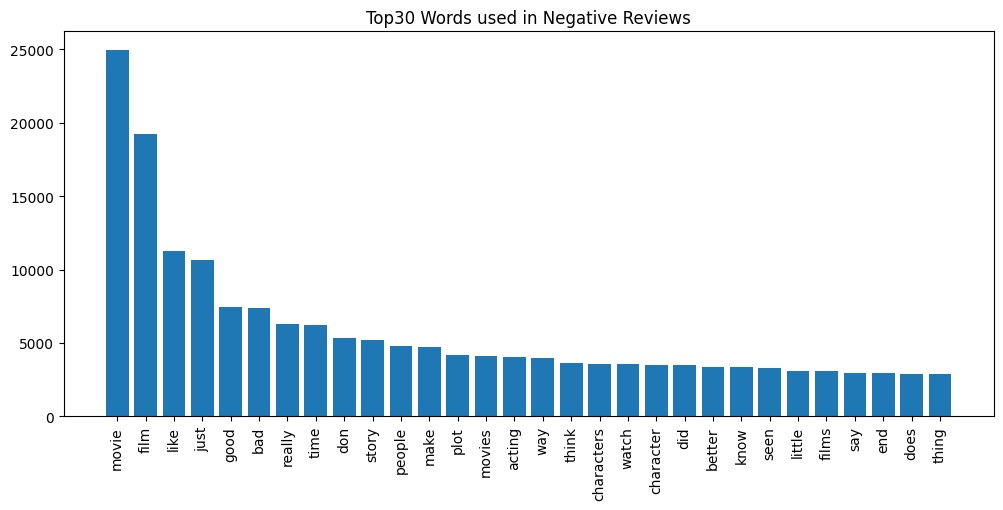

In [198]:
# find top 20 words in negative reviews
train_neg_df = train_df[train_df['label'] == 0]

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english', max_df=0.8 ,min_df=100)
bag_of_words = count_vectorizer.fit_transform(train_neg_df['text'])
sum_words = bag_of_words.sum(axis=0)

words_freq = [
    (word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()
]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

x, y = zip(*words_freq[:30])

plt.figure(figsize=(12,5))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Top30 Words used in Negative Reviews')
#!mkdir assets
#plt.savefig('assets/Negative_word.webp', bbox_inches='tight')

Text(0.5, 1.0, 'Top30 Words used in Positive Reviews')

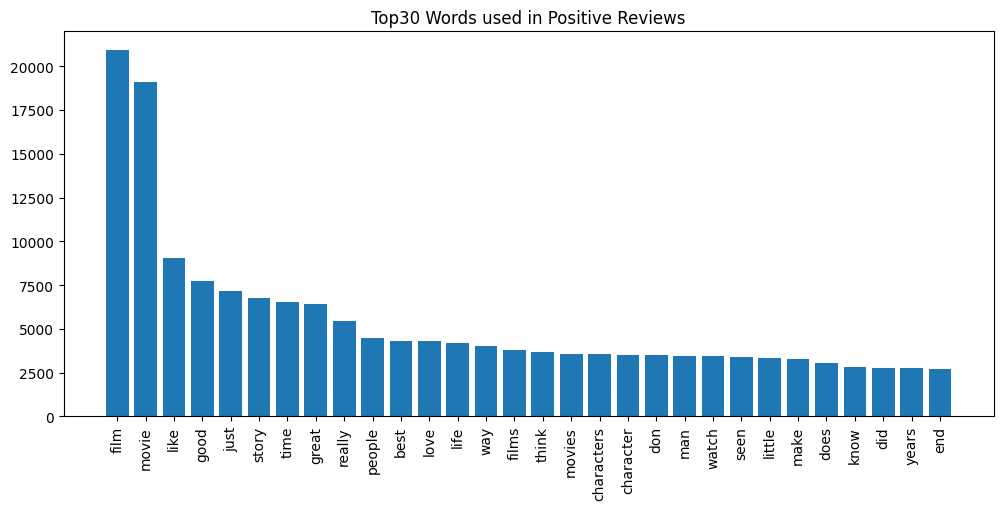

In [199]:
# find top 20 words in positive reviews
train_pos_df = train_df[train_df['label'] == 1]

count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
bag_of_words = count_vectorizer.fit_transform(train_pos_df['text'])
sum_words = bag_of_words.sum(axis=0)

words_freq = [
    (word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()
]

words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

x, y = zip(*words_freq[:30])

plt.figure(figsize=(12,5))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Top30 Words used in Positive Reviews')

#plt.savefig('assets/Positive_words.webp', bbox_inches='tight')

In [200]:
X_rev_train = train_df['text']
y_rev_train = train_df['label']

X_rev_test = test_df['text']
y_rev_test = test_df['label']

In [201]:
#vect = CountVectorizer().fit(X_rev_train)
vect = CountVectorizer(binary=False, max_df=0.80, min_df=10, max_features=10000, stop_words="english").fit(X_rev_train)

X_train = vect.transform(X_rev_train)
X_test = vect.transform(X_rev_test)
print("X_train:\n{}".format(repr(X_train)))


X_train:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1945120 stored elements and shape (25000, 10000)>


In [202]:
X_train[0]

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 98 stored elements and shape (1, 10000)>

In [203]:
print("Vocabulary: ", vect.vocabulary_)

Vocabulary:  {'rented': np.int64(7350), 'curious': np.int64(2140), 'yellow': np.int64(9964), 'video': np.int64(9562), 'store': np.int64(8578), 'controversy': np.int64(1920), 'surrounded': np.int64(8790), 'released': np.int64(7294), 'heard': np.int64(4127), 'customs': np.int64(2154), 'tried': np.int64(9257), 'enter': np.int64(2990), 'country': np.int64(1996), 'fan': np.int64(3271), 'films': np.int64(3401), 'considered': np.int64(1867), 'controversial': np.int64(1919), 'really': np.int64(7180), 'plot': np.int64(6655), 'centered': np.int64(1377), 'young': np.int64(9974), 'swedish': np.int64(8821), 'drama': np.int64(2692), 'student': np.int64(8639), 'named': np.int64(5947), 'lena': np.int64(5139), 'wants': np.int64(9680), 'learn': np.int64(5113), 'life': np.int64(5185), 'particular': np.int64(6415), 'focus': np.int64(3497), 'making': np.int64(5441), 'sort': np.int64(8321), 'documentary': np.int64(2623), 'average': np.int64(598), 'thought': np.int64(9030), 'certain': np.int64(1386), 'politi

In [204]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::1000]))


Number of features: 10000
First 20 features:
['aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'abducted' 'abilities'
 'ability' 'able' 'aboard' 'abominable' 'abomination' 'abortion' 'abound'
 'abraham' 'abroad' 'abrupt' 'abruptly' 'absence' 'absent']
Features 5010 to 5030:
['kurosawa' 'kurt' 'kusturica' 'kyle' 'la' 'lab' 'label' 'labeled' 'labor'
 'laboratory' 'labyrinth' 'laced' 'lack' 'lacked' 'lacking' 'lackluster'
 'lacks' 'ladder' 'laden' 'ladies']
Every 2000th feature:
['aaron' 'bothering' 'coup' 'entertains' 'ha' 'kramer' 'negative' 'punk'
 'shaun' 'theft']


In [205]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

scores = cross_val_score(LogisticRegression(), X_train, y_rev_train, cv=3)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.82


CountVectorizer to Extracting Features from Text

https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/

In [206]:
nb_vec = LogisticRegression()
nb_vec.fit(X_train, y_rev_train)
preds = nb_vec.predict(X_test)
print(classification_report(y_rev_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.86      0.84      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [207]:
#Show weights for BOW
# https://www.nlplanet.org/course-practical-nlp/01-intro-to-nlp/04-n-grams
# create a pandas dataframe that shows the unigrams in each text
keys_values_sorted = sorted(list(vect.vocabulary_.items()), key=lambda t: t[1])
keys_sorted = list(zip(*keys_values_sorted))[0]

# show logistic regression weights
from_unigram_to_weight = dict(zip(keys_sorted, nb_vec.coef_[0]))
from_unigram_to_weight
print('Positive')
sorted(zip(nb_vec.coef_[0].round(3) , keys_sorted) , reverse = True)[:20]


Positive


[(np.float64(1.935), 'refreshing'),
 (np.float64(1.717), 'vengeance'),
 (np.float64(1.627), 'flawless'),
 (np.float64(1.598), 'funniest'),
 (np.float64(1.555), 'wonderfully'),
 (np.float64(1.54), 'cerebral'),
 (np.float64(1.538), 'hooked'),
 (np.float64(1.534), 'kurosawa'),
 (np.float64(1.468), 'erotic'),
 (np.float64(1.428), 'appreciated'),
 (np.float64(1.421), 'carrey'),
 (np.float64(1.415), 'kitty'),
 (np.float64(1.412), 'mj'),
 (np.float64(1.398), 'perfectly'),
 (np.float64(1.396), 'chavez'),
 (np.float64(1.376), 'spring'),
 (np.float64(1.375), 'delightful'),
 (np.float64(1.367), 'scariest'),
 (np.float64(1.359), 'marvelous'),
 (np.float64(1.358), 'shannon')]

In [208]:
print('Negative')
sorted(zip(nb_vec.coef_[0] , keys_sorted) , reverse = False)[:20]

Negative


[(np.float64(-2.4880034861993163), 'disappointment'),
 (np.float64(-2.4243323289789513), 'waste'),
 (np.float64(-2.0418348619574185), 'worst'),
 (np.float64(-2.002760876576944), 'poorly'),
 (np.float64(-1.8783138188729542), 'baldwin'),
 (np.float64(-1.7652969445076228), 'lacks'),
 (np.float64(-1.7264969450096976), 'boredom'),
 (np.float64(-1.7034852194380834), 'alright'),
 (np.float64(-1.6893412247549082), 'awful'),
 (np.float64(-1.6861522184956086), 'unfunny'),
 (np.float64(-1.6777578023762123), 'generous'),
 (np.float64(-1.6593836279112155), 'forgettable'),
 (np.float64(-1.6551488084636914), 'mess'),
 (np.float64(-1.5897250350519165), 'unwatchable'),
 (np.float64(-1.5655952592004776), 'unremarkable'),
 (np.float64(-1.550069515364851), 'refer'),
 (np.float64(-1.543867782640846), 'mediocre'),
 (np.float64(-1.5366450791032387), 'lifeless'),
 (np.float64(-1.5352807151057157), 'mildly'),
 (np.float64(-1.5326398153505059), 'fails')]

# **TfidfVectorizer**

The TfidfVectorizer is a feature extraction technique in the scikit-learn library for converting a collection of raw text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. This is a common step in Natural Language Processing (NLP) and text mining tasks to transform text data into numerical data that machine learning algorithms can work with.

How TfidfVectorizer Works
Term Frequency (TF): This measures how frequently a term (word) appears in a document. The assumption is that the more frequently a term appears in a document, the more important it is. However, this alone can be misleading, as common words (like "the", "is", "and") will appear frequently in many documents.
Inverse Document Frequency (IDF): This measures how important a term is by considering how often it appears across all documents in the dataset. The more documents a term appears in, the less important it is. The IDF value of a term decreases as the number of documents containing the term increases.
TF-IDF: The product of TF and IDF. This score gives us an indication of how important a term is within a particular document while reducing the weight of commonly occurring terms that are less informative.
Formula of TF-IDF
The TF-IDF score for a term t in a document d is calculated as:

tf-idf
(
t
,
d
)
=
tf
(
t
,
d
)
×
idf
tf-idf(t,d)=tf(t,d)×idf

Where:

tf
(
t
,
d
)
tf(t,d)
 is the term frequency of term t in document d.
idf
(
t
)
idf(t)
 is the inverse document frequency of term t, calculated as:
idf
(
t
)
=
log
⁡
(
N
1
+
df
(
t
)
)
idf(t)=log(
1+df(t)
N
​
 )

Where:

N is the total number of documents.
df
(
t
)
df(t)
 is the number of documents containing the term t.
 https://www.geeksforgeeks.org/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/

 https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/


In [209]:
tfidf_rev_vec = TfidfVectorizer(
    binary=False, max_df=0.80, min_df=10,
    max_features=10000
)

X_rev_tfidf_train = tfidf_rev_vec.fit_transform(X_rev_train)
X_rev_tfidf_test = tfidf_rev_vec.transform(X_rev_test)

In [210]:
# print idf values
df_idf = pd.DataFrame(tfidf_rev_vec.idf_, index=vect.get_feature_names_out(),columns=["idf_weights"])

# sort ascending
df_idf.sort_values(by=['idf_weights'])

,idf_weights
café,1.329545
follows,1.334898
wishes,1.358545
want,1.436006
asleep,1.438917
...,...
laid,8.728776
esther,8.728776
misguided,8.728776
item,8.728776


In [211]:
nb_rev = LogisticRegression()
nb_rev.fit(X_rev_tfidf_train, y_rev_train)

LogisticRegression()

In [212]:
preds = nb_rev.predict(X_rev_tfidf_test)
print(classification_report(y_rev_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



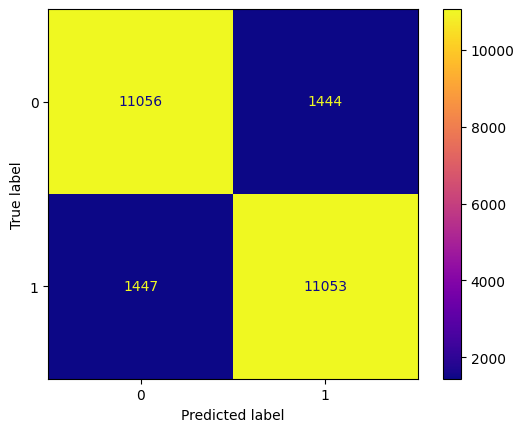

In [213]:
conf_mtx = confusion_matrix(y_rev_test, preds)
conf_mtx_plot = ConfusionMatrixDisplay(
     confusion_matrix=conf_mtx
)
conf_mtx_plot.plot(cmap='plasma')

In [214]:
#Show weights for BOW
# https://www.nlplanet.org/course-practical-nlp/01-intro-to-nlp/04-n-grams
# create a pandas dataframe that shows the unigrams in each text
keys_values_sorted = sorted(list(tfidf_rev_vec.vocabulary_.items()), key=lambda t: t[1])
keys_sorted = list(zip(*keys_values_sorted))[0]

# show logistic regression weights
from_unigram_to_weight = dict(zip(keys_sorted, nb_rev.coef_[0]))
from_unigram_to_weight
print('Positive')
sorted(zip(nb_rev.coef_[0] , keys_sorted) , reverse = True)[:20]

Positive


[(np.float64(6.852772605271699), 'great'),
 (np.float64(6.096314157281785), 'excellent'),
 (np.float64(4.969231763579047), 'perfect'),
 (np.float64(4.833481416950322), 'best'),
 (np.float64(4.609533196541506), 'wonderful'),
 (np.float64(4.132599185579824), 'amazing'),
 (np.float64(3.7790305024456297), 'loved'),
 (np.float64(3.7674999969812815), 'today'),
 (np.float64(3.7156831677044515), 'well'),
 (np.float64(3.6807501822605015), 'favorite'),
 (np.float64(3.617282310184663), 'fun'),
 (np.float64(3.4981325658346054), 'enjoyed'),
 (np.float64(3.386883065106592), 'highly'),
 (np.float64(3.383095052995311), 'brilliant'),
 (np.float64(3.3752200472555023), 'love'),
 (np.float64(3.347388916365937), 'superb'),
 (np.float64(3.0952928793995125), 'enjoyable'),
 (np.float64(3.090352939443563), 'definitely'),
 (np.float64(3.0338525165276358), 'bit'),
 (np.float64(2.951747140415009), 'liked')]

In [215]:
print('Negative')
sorted(zip(nb_rev.coef_[0] , keys_sorted) , reverse = False)[:20]

Negative


[(np.float64(-8.991030901767955), 'worst'),
 (np.float64(-6.995133312802143), 'bad'),
 (np.float64(-6.3358088774884616), 'awful'),
 (np.float64(-6.266398902995994), 'waste'),
 (np.float64(-5.691925038700537), 'boring'),
 (np.float64(-5.260116588559758), 'poor'),
 (np.float64(-4.486624670782749), 'terrible'),
 (np.float64(-4.449528852990042), 'nothing'),
 (np.float64(-4.347880742950444), 'worse'),
 (np.float64(-4.294047800970586), 'poorly'),
 (np.float64(-4.287829369393077), 'dull'),
 (np.float64(-4.087295650565891), 'unfortunately'),
 (np.float64(-4.087009713539604), 'horrible'),
 (np.float64(-3.870569577553079), 'no'),
 (np.float64(-3.8322762380749746), 'disappointment'),
 (np.float64(-3.8017959288998564), 'annoying'),
 (np.float64(-3.733045497447551), 'disappointing'),
 (np.float64(-3.667684657274967), 'ridiculous'),
 (np.float64(-3.6149026344774193), 'fails'),
 (np.float64(-3.556734003849909), 'stupid')]

# **Let's build a pipline**

In [216]:
from sklearn.naive_bayes import BernoulliNB
#('clf', LogisticRegression(solver='lbfgs')),])
#('clf', DecisionTreeClassifier(max_depth=35))])

text_clf = Pipeline([('vect', CountVectorizer(stop_words='english',max_features=10000,ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(fit_intercept=True))])

In [217]:
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

0.8824

In [218]:
print(text_clf.predict(['false awful we we bla bla bla great great']))
print(text_clf.predict_proba(['false awful we we bla bla bla great great']))

[1]
[[0.40178926 0.59821074]]


# **Let's add PCA/SVD to our features**

In [219]:
from sklearn.decomposition import TruncatedSVD

text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', max_features=10000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=500, random_state=42)),  # no need to densify!
    ('clf', LogisticRegression(fit_intercept=True))
])

In [220]:
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

0.87428

In [221]:
print(text_clf.predict(['false awful we we bla bla bla great great']))
print(text_clf.predict_proba(['false awful we we bla bla bla great great']))

[1]
[[0.32560762 0.67439238]]


# Vocabulary Stemmer and Lemmatization

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
nltk.download('stopwords')
stop_words = stopwords.words('english')

pipelineSGD = Pipeline([
    ('vectorizer', CountVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features = None)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, max_iter=60))
])

pipelineSGD.fit(X_rev_train, y_rev_train)

y_predSGD = pipelineSGD.predict(X_rev_test)
print("Predicted: ", y_predSGD)

print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_predSGD)*100, "%")

In [ ]:
from sklearn.svm import LinearSVC

pipelineSVM = Pipeline([
    ('vectorizer', CountVectorizer(stop_words = stop_words, ngram_range = (1,2), max_features = None)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(C = 0.5, max_iter = 1000, penalty = 'l2', tol = 0.01))
])


pipelineSVM.fit(X_rev_train, y_rev_train)

y_predSVM = pipelineSVM.predict(X_rev_test)
print("Predicted: ", y_predSVM)

print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_predSVM)*100, "%")

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(analyzer='word', token_pattern=r'\w{2,}',  strip_accents='unicode', stop_words=stop_words, max_features=10000,ngram_range=(1,1))),
                     ('tfidf', TfidfTransformer()), ('clf', LogisticRegression()),])
text_clf.fit(X_rev_train, y_rev_train)
text_clf.score(X_rev_test,y_rev_test)

In [ ]:
# Most common words that were used in positive reviews
#https://github.com/Kasra1377/IMDB-sentiment-analysis/blob/master/data-preprocessing.ipynb
features = text_clf['vect'].get_feature_names_out()
sorted(zip(text_clf['clf'].coef_[0] , features) , reverse = True)[:20]


In [ ]:
# Most common words that were used in negative reviews
sorted(zip(text_clf['clf'].coef_[0] , features))[:20]

Examining the Model Performance

In [ ]:

text = "DONT WATCH THIS MOVIE. its a complete trash"

In [ ]:
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
CLEAN = re.compile("<.*?>")    # to remove everything between "<>"
result = re.sub(CLEAN, " ", text)
result = re.sub("[^a-zA-Z]" , " " , result)
result = result.lower()
result = result.split()   # to break sentences into words
word = [ps.stem(word) for word in result if word not in stopwords.words("english")]
result = " ".join(word)
print(result)

In [ ]:
print(text_clf.predict_proba([text]))

# **The best sklearn result**

In [ ]:
#https://www.kaggle.com/code/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(["book"])

pipe = make_pipeline(TfidfVectorizer(
                                    stop_words='english',
                                    strip_accents='unicode',
                                    token_pattern=r'\w{1,}', #accept tokens that have 1 or more characters
                                    analyzer='word',
                                    ngram_range=(1, 2),
                                    min_df=100),
                     LinearSVC(C = 0.5, max_iter = 1000, penalty = 'l2', tol = 0.01))
param_grid = {'tfidfvectorizer__max_features': [None],
              'tfidfvectorizer__sublinear_tf': [True],
              'tfidfvectorizer__smooth_idf': [True],
              'tfidfvectorizer__use_idf': [True],
              'tfidfvectorizer__stop_words': [None],
              'linearsvc__C': [ 0.1],

             }
grid = GridSearchCV(pipe, param_grid, cv=3)

grid3 = grid.fit(X_rev_train, y_rev_train)



In [ ]:
print(grid3.best_params_)
print(grid3.best_score_)


In [ ]:
grid3.score(X_rev_test,y_rev_test)

In [ ]:
# for the comparition best results:
# https://paperswithcode.com/sota/sentiment-analysis-on-imdb

In [ ]:
print(grid3.predict(['ok recommended its greate 10 of 10 movie']))

In [ ]:
y_pred=grid3.predict(X_rev_test)

In [ ]:
print("Accuracy: ", metrics.accuracy_score(y_rev_test, y_pred)*100, "%")

In [ ]:
y_test = np.asarray(y_rev_test)
misclassified = np.where(y_test != grid3.predict(X_rev_test))
len(misclassified[0])

In [ ]:
i=2000
print('True label=',y_test[misclassified[0][i]], ' predicted =', 1-y_test[misclassified[0][i]] )
X_rev_test[misclassified[0][i]]


In [ ]:
cm=confusion_matrix(y_test, grid3.predict(X_rev_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=grid3.classes_)
disp.plot()
plt.show()